In [101]:
import sys
import os

# Path to the project root (one level above notebooks/)
project_root = os.path.abspath("..")

# Add to Python path
sys.path.append(project_root)


import weedcrop.dataset
import weedcrop.evaluation as eval_mod
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from random import randint
from PIL import Image

from skimage import data, exposure

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

import numpy as np

In [2]:
ds = weedcrop.dataset.create_dataset_list()
min_width, min_height = weedcrop.dataset.find_min_dim(ds)

Minimum resolution: (360, 360)


In [3]:
ds[0]

['../data/img/12114.jpg', 'weed']

### Notes:

**Dataset imbalance**: More weeds than crops.

**Minimum resolution**: Have to resize all images to match min resolution - uniformity.

---

Now that we have the list of image files, let's extract some features.

## Histogram of Oriented Gradients - HOG - Feature extraction

Used in shape recongnition.

For each image in the dataset:
1. Load image
2. Convert the image to grayscale
3. Resize the image to match min resolution
4. Extract HOG
5. Append to list with features

In [4]:
%%time

X_hog_features, y_hog_labels, X_hog_visual = [], [], []
for i in range(len(ds)):
    
    img = cv2.imread(ds[i][0])
    img_resized = cv2.resize(img, (min_width, min_height))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    if i%200 == 0:
        
        # Sample visual image
        hog_features, hog_visual = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True
        )
        X_hog_visual.append([ [i], [hog_visual] ])
        
    else:
        
        # Skip visual, just exctract features
        hog_features = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        
    # Collect features and labels
    X_hog_features.append(hog_features)
    y_hog_labels.append(ds[i][1])

CPU times: user 41.5 s, sys: 989 ms, total: 42.5 s
Wall time: 41.3 s


In [5]:
len(X_hog_features), len(y_hog_labels)

(1176, 1176)

In [6]:
len(X_hog_features[0])

69696

In [7]:
8*8*2*2*9

2304

In [8]:
X_hog_features[0]

array([0.28475655, 0.        , 0.02391007, ..., 0.18594874, 0.25146204,
       0.25146204])

In [9]:
len(X_hog_visual)

6

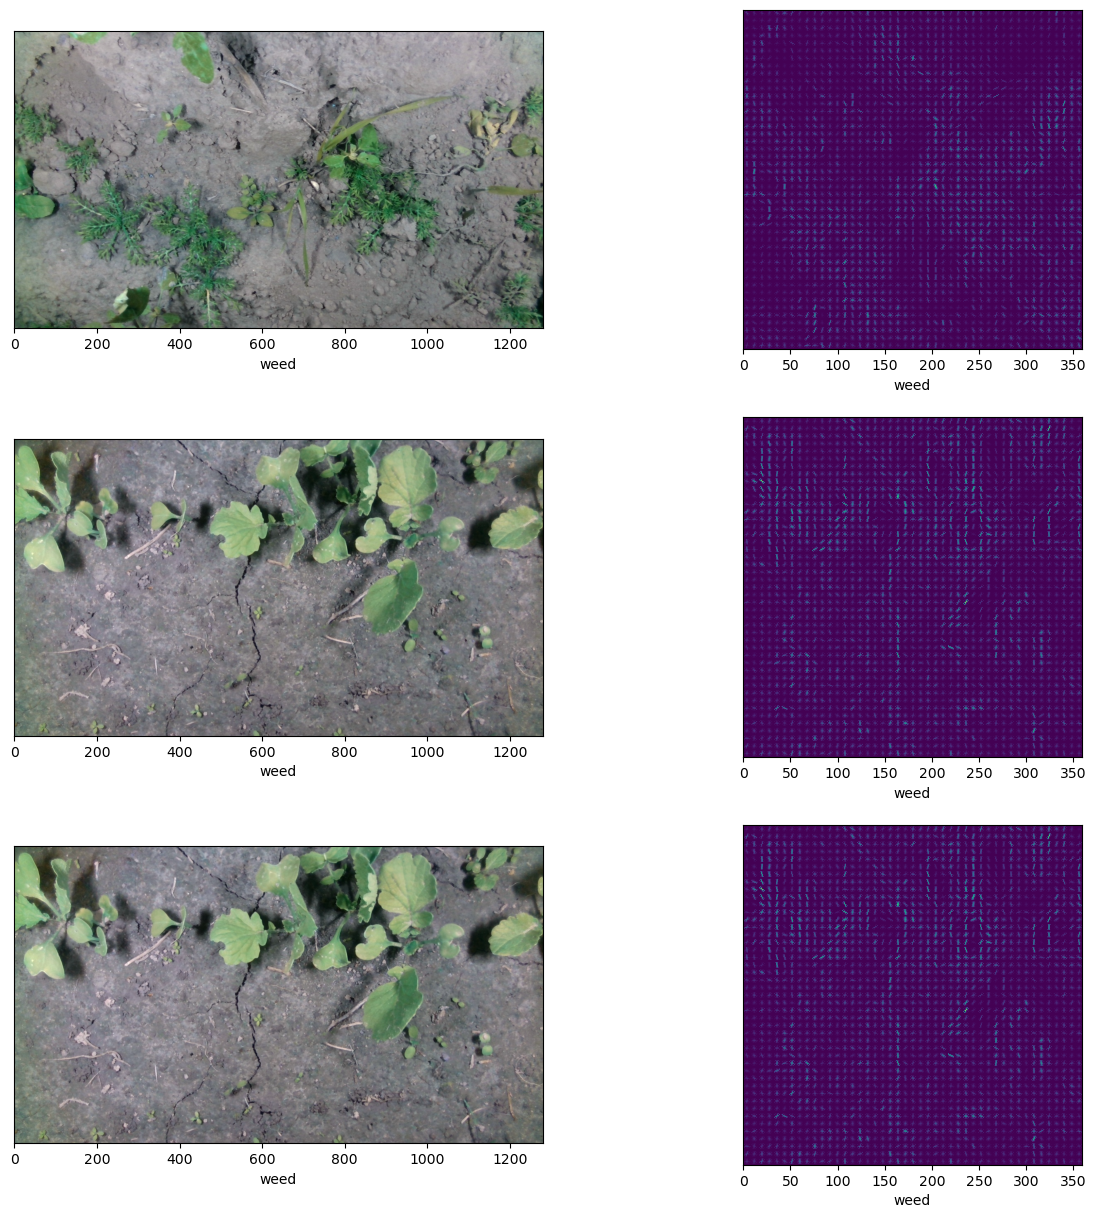

In [10]:
# How do images look like now?
nof_cols = 2
nof_rows = 3

fig, axes = plt.subplots(nrows=nof_rows, ncols=nof_cols, figsize=(15, 15))

for axs in axes:
    axs[0].get_yaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])
    
    rand_record_visual = randint(0, len(X_hog_visual)-1)
    
    # Set label
    axs[0].set_xlabel(xlabel = ds[ X_hog_visual[ rand_record_visual ][0][0] ][1])
    axs[1].set_xlabel(xlabel = ds[ X_hog_visual[ rand_record_visual ][0][0] ][1])
    
    # Set images
    axs[0].imshow(cv2.imread(ds[X_hog_visual[rand_record_visual][0][0]][0]))
    axs[1].imshow(X_hog_visual[rand_record_visual][1][0])

HOG extractecd, does not look so useful to the human eye at least.

---

# RandomForest classifier

**Notes**

Because the dataset is imbalanced, let's train a classifier with 2 classes, weed and not weed instead of weed and crop.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hog_features,
    y_hog_labels,
    train_size=0.8,
    stratify=y_hog_labels
)

In [12]:
print(
f"""Train samples: {len(X_train)}
Train labels: {len(y_train)}\n
Test samples: {len(X_test)}
Test labels: {len(y_test)}"""
)

Train samples: 940
Train labels: 940

Test samples: 236
Test labels: 236


In [13]:
%%time
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

CPU times: user 5.55 s, sys: 35.4 ms, total: 5.59 s
Wall time: 5.61 s


#### TODO - function

Evaluation

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.92%


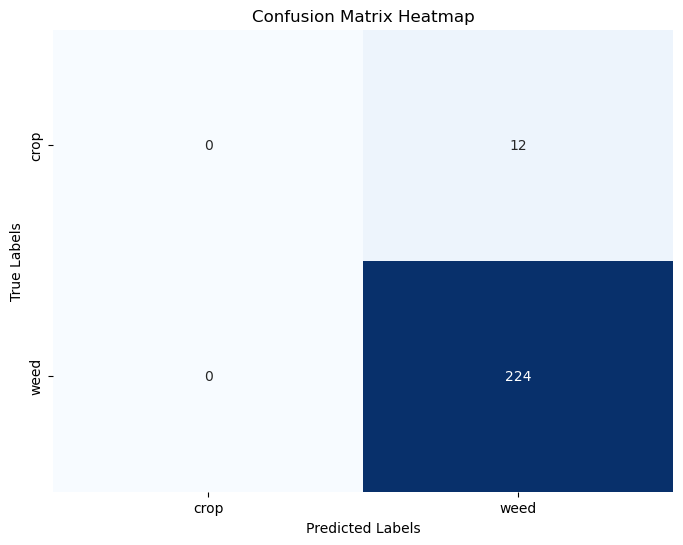

In [15]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["crop", "weed"], yticklabels=["crop", "weed"])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [16]:
print(f"Accuracy: {sum(conf_matrix.diagonal())/sum(conf_matrix.flatten())}")

Accuracy: 0.9491525423728814


In [17]:
recall_crop = conf_matrix[0][0]/conf_matrix[0].flatten().sum()
recall_weed = conf_matrix[1][1]/conf_matrix[1].flatten().sum()
print(f"Recall Crop: {recall_crop}")
print(f"Recall Weed: {recall_weed}")

Recall Crop: 0.0
Recall Weed: 1.0


**High Recall** (closer to 1.0 or 100%): Indicates the model is very good at identifying all existing positive instances, resulting in very few false negatives (missed cases).

**Low Recall** (closer to 0): Indicates the model misses a large percentage of the actual positive instances, leading to many false negatives

Low recall on the crop shows that the model is bad at finding crops among weeds.

Surely this has to do with the fact that the dataset is highly imbalanced and the model does not learn to recognize crops very well.

In [18]:
import math
precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
if math.isnan(precision_crop):
    precision_crop = 0
prevision_weed = conf_matrix[1][1]/conf_matrix[:,1].sum()
print(f"Precision Crop: {precision_crop}")
print(f"Precision Weed: {prevision_weed}")

Precision Crop: 0
Precision Weed: 0.9491525423728814


/tmp/ipykernel_3338965/966795271.py:2: RuntimeWarning: invalid value encountered in scalar divide
  precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()


When the model sees a crop, it's highly certain that it's a crop. But, it does not dare to make that assumption many times. The models underfits for crop.

It makes more correct predictions for weed.

In [19]:
f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)
if math.isnan(f1_score_crop):
    f1_score_crop = 0
f1_score_weed = (2*prevision_weed*recall_weed)/(prevision_weed+recall_weed)
print(f"F1 score Crop: {f1_score_crop}")
print(f"F1 score Weed: {f1_score_weed}")

F1 score Crop: 0
F1 score Weed: 0.9739130434782608


/tmp/ipykernel_3338965/2006460474.py:1: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)


Low F1-score for the Crop class indicates that the model made a lot of False-Positive predictions - missclassified Crop as Weed.

High F1-score for the Weed class indicates the model made a lot of True-Positive predictions - correctly classified the Weed class.

Let's calculate **Macro F1** which is especially important for imabalanced datasets.

In [20]:
f1_macro = (f1_score_crop + f1_score_weed) / 2
f1_macro

0.4869565217391304

As expected, `macro F1` is nowhere close to 1 which indicates a poor model performance for one of the classes.

## Meeting with professor

- Test other classifiers.

1.Simplest-naive: balanced training dataset.

THrow away dominant class - with a more balanced ds.

2. Weighting on priors

3. Augmentation:

- SMOTE(features) only on train (on small sample)
- Measure macro-f1 score (different than just f1 score) - 2-3% improvement
- image augmentation - use ready


**Notes**

- Look for a library which can do augmentation automatically - don't reinvent the wheel.

---

# PyCaret

All in one feature extraction and model training library.


In [21]:
import pycaret.classification as clf
import pandas as pd

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f99e6764430>
Traceback (most recent call last):
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'spl

Create dataframe

In [22]:
img_path = []
for line in ds:
    img_path.append(line[0])

In [23]:
img_type = []
for line in ds:
    img_type.append(line[1])

In [24]:
df = pd.DataFrame({"image": img_path, "type": img_type})

In [25]:
df.head(5)

,image,type
0,../data/img/12114.jpg,weed
1,../data/img/12120.jpg,weed
2,../data/img/12122.jpg,weed
3,../data/img/12123.jpg,weed
4,../data/img/12147.jpg,weed


In [26]:
df.describe()

,image,type
count,1176,1176
unique,1176,2
top,../data/img/IMG_6203.JPG,weed
freq,1,1116


In [27]:
df.type.unique()

array(['weed', 'crop'], dtype=object)

In [28]:
# Setup
clf.setup(data=df, target="type", session_id=123, fix_imbalance=True)

,Description,Value
0,Session id,123
1,Target,type
2,Target type,Binary
3,Target mapping,"crop: 0, weed: 1"
4,Original data shape,"(1176, 2)"
5,Transformed data shape,"(1915, 2)"
6,Transformed train set shape,"(1562, 2)"
7,Transformed test set shape,"(353, 2)"
8,Categorical features,1
9,Preprocess,True


In [29]:
# Build and Compare models

best = clf.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.2560
knn,K Neighbors Classifier,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0130
nb,Naive Bayes,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0090
dt,Decision Tree Classifier,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0100
svm,SVM - Linear Kernel,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0120
ridge,Ridge Classifier,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0110
rf,Random Forest Classifier,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0400
qda,Quadratic Discriminant Analysis,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0090
ada,Ada Boost Classifier,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0090
gbc,Gradient Boosting Classifier,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000,0.0200


In [30]:
# Print best model
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [31]:
clf.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [32]:
preds = clf.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000


In [33]:
preds = clf.predict_model(best)
preds.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9490,0.5000,0.9490,0.9006,0.9242,0.0000,0.0000


,image,type,prediction_label,prediction_score
81,../data/img/32196.jpg,weed,weed,0.7715
771,../data/img/34060.jpg,weed,weed,0.7715
361,../data/img/32688.jpg,weed,weed,0.7715
803,../data/img/34110.jpg,weed,weed,0.7715
957,../data/img/IMG_5935.JPG,weed,weed,0.7715


In [34]:
preds.shape

(353, 4)

In [35]:
clf.get_config('X_train')

,image
300,../data/img/32536.jpg
275,../data/img/32502.jpg
253,../data/img/32479.jpg
1137,../data/img/IMG_6164.JPG
1095,../data/img/IMG_6112.JPG
...,...
56,../data/img/32171.jpg
892,../data/img/37095.jpg
336,../data/img/32615.jpg
916,../data/img/37683.jpg


---

# Local Binary Pattern - LBP

For each image in the dataset:
1. Load image
2. Convert the image to grayscale
3. Resize the image to match min resolution
4. Extract LBP
5. Get the histogram of LBP
6. Append to list with features

In [36]:
#|export

from skimage import feature

def extract_lbp_features(ds):
    
    X_lbp_features, y_lbp_labels = [], []
    min_width, min_height = weedcrop.dataset.find_min_dim(ds)
    
    for i in range(len(ds)):
        img = cv2.imread(ds[i][0])
        img_resized = cv2.resize(img, (min_width, min_height))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        lbp = feature.local_binary_pattern(img_gray, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)        

        # Collect features and labels
        X_lbp_features.append(lbp_hist)
        y_lbp_labels.append(ds[i][1])
    return X_lbp_features, y_lbp_labels

In [37]:
%%time
X_lbp_features, y_lbp_labels = extract_lbp_features(ds)
len(X_lbp_features), len(y_lbp_labels)

Minimum resolution: (360, 360)
CPU times: user 17.5 s, sys: 848 ms, total: 18.3 s
Wall time: 17.2 s


(1176, 1176)

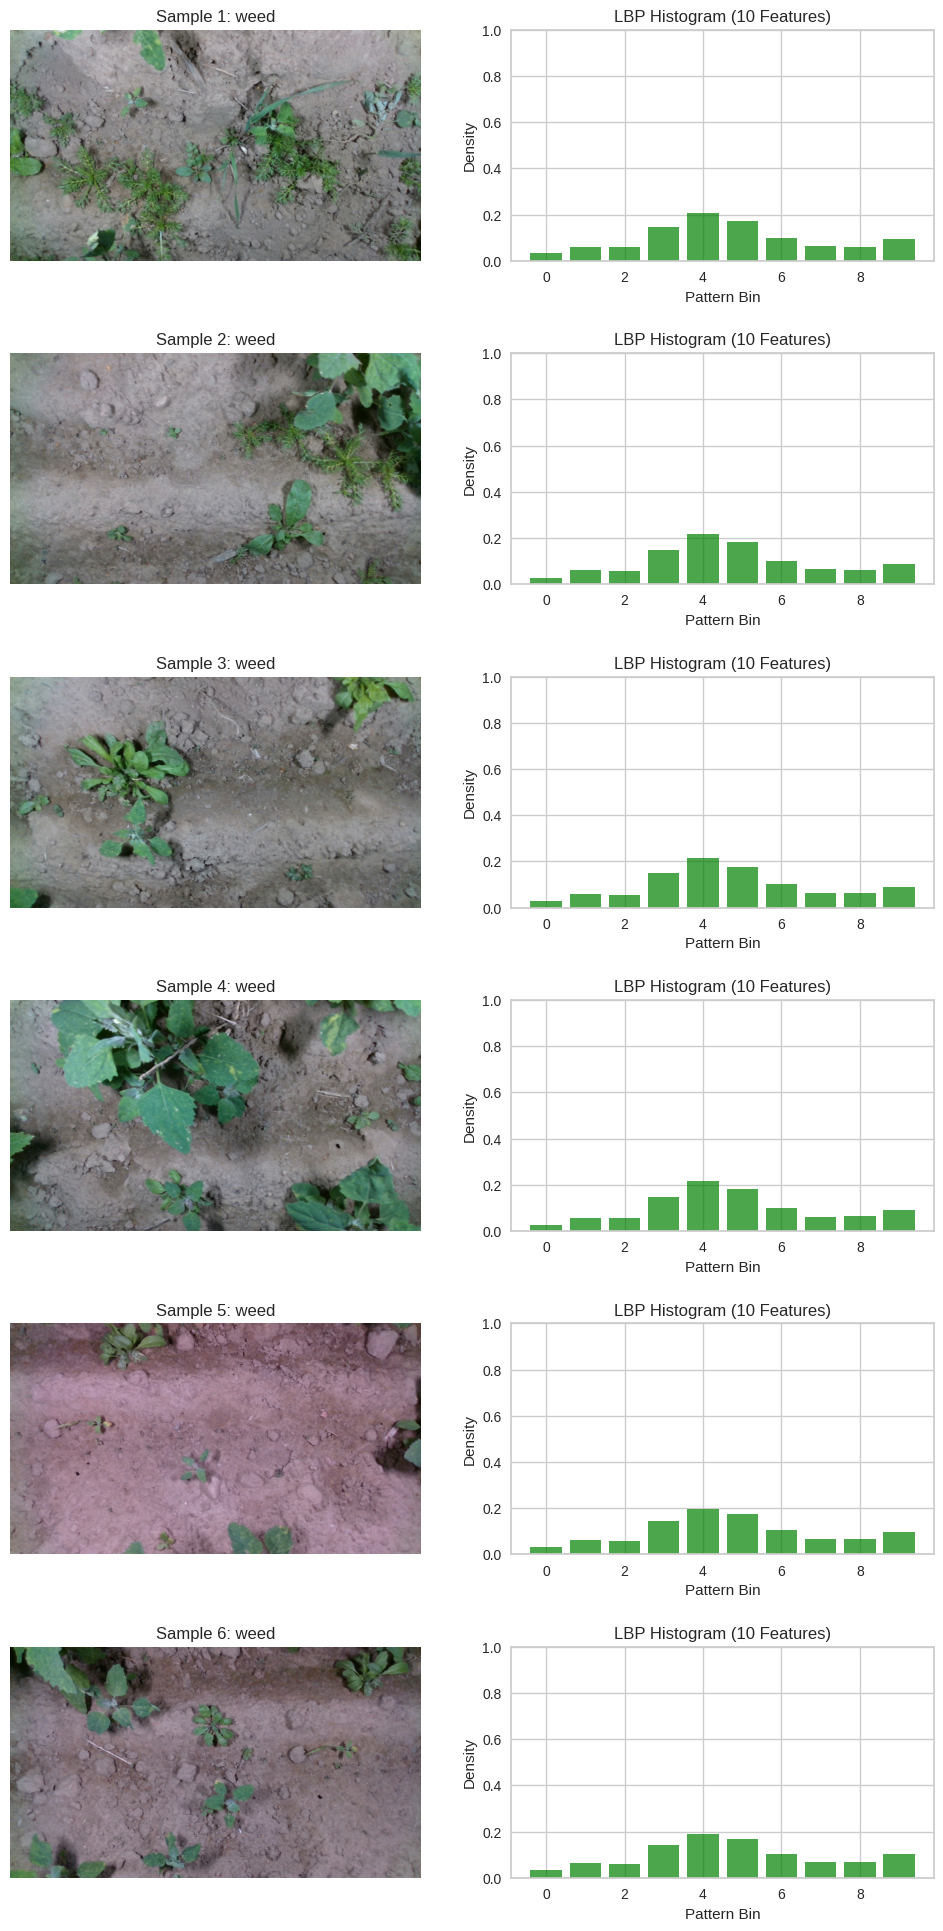

CPU times: user 1.57 s, sys: 178 ms, total: 1.75 s
Wall time: 1.53 s


In [38]:
%%time

import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

# 1. Setup the figure
fig, axes = plt.subplots(6, 2, figsize=(12, 24))
plt.subplots_adjust(hspace=0.4)

# 2. Loop through 6 samples
for i in range(6):
    # Load and process image
    img_path = ds[i][0]
    label = ds[i][1]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate LBP (Texture)
    # P=8, R=1, 'uniform' matches your extraction function
    lbp = local_binary_pattern(img_gray, P=8, R=1, method='uniform')
    
    # Calculate Histogram
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Plot Image
    axes[i, 0].imshow(img_rgb)
    axes[i, 0].set_title(f"Sample {i+1}: {label}")
    axes[i, 0].axis('off')

    # Plot Histogram
    axes[i, 1].bar(range(n_bins), hist, color='green', alpha=0.7)
    axes[i, 1].set_title(f"LBP Histogram (10 Features)")
    axes[i, 1].set_xlabel("Pattern Bin")
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].set_ylim(0, 1)

plt.show()

# Feature Fusion

Create a single "super-vector" that contains all features.

In [39]:
X_hog = np.array(X_hog_features)
X_lbp = np.array(X_lbp_features)

X_combined = np.hstack([X_hog, X_lbp])

X_combined.shape

(1176, 69706)

In [40]:
# TODO create feature fusion function
def feature_fusion(super_vector=None, features = []):
    pass
    """ Fuses a list of features into a super-vector. """
    if super_vector == None:
        super_vector = np.hstack([])
    return super_vector

---

# Retrain Random Forest with LBP

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_hog_labels,
    train_size=0.8,
    stratify=y_hog_labels # Fix imbalance
)

In [42]:
print(
f"""Train samples: {len(X_train)}
Train labels: {len(y_train)}\n
Test samples: {len(X_test)}
Test labels: {len(y_test)}"""
)

Train samples: 940
Train labels: 940

Test samples: 236
Test labels: 236


In [43]:
%%time
classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    criterion="gini"
)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

CPU times: user 5.14 s, sys: 32 ms, total: 5.18 s
Wall time: 5.19 s


In [44]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.92%


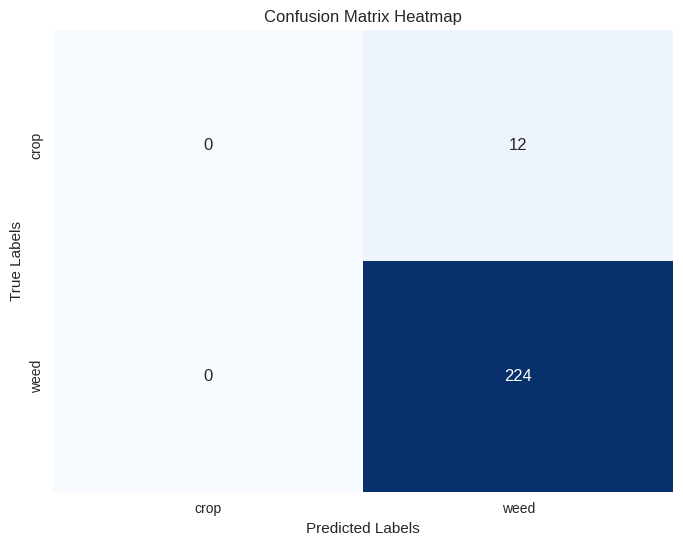

In [45]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["crop", "weed"], yticklabels=["crop", "weed"])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [46]:
print(f"Accuracy: {sum(conf_matrix.diagonal())/sum(conf_matrix.flatten())}")

Accuracy: 0.9491525423728814


In [47]:
recall_crop = conf_matrix[0][0]/conf_matrix[0].flatten().sum()
recall_weed = conf_matrix[1][1]/conf_matrix[1].flatten().sum()
print(f"Recall Crop: {recall_crop}")
print(f"Recall Weed: {recall_weed}")

Recall Crop: 0.0
Recall Weed: 1.0


**High Recall** (closer to 1.0 or 100%): Indicates the model is very good at identifying all existing positive instances, resulting in very few false negatives (missed cases).

**Low Recall** (closer to 0): Indicates the model misses a large percentage of the actual positive instances, leading to many false negatives

Low recall on the crop shows that the model is bad at finding crops among weeds.

Surely this has to do with the fact that the dataset is highly imbalanced and the model does not learn to recognize crops very well.

In [48]:
import math
precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
if math.isnan(precision_crop):
    precision_crop = 0
prevision_weed = conf_matrix[1][1]/conf_matrix[:,1].sum()
print(f"Precision Crop: {precision_crop}")
print(f"Precision Weed: {prevision_weed}")

Precision Crop: 0
Precision Weed: 0.9491525423728814


When the model sees a crop, it's highly certain that it's a crop. But, it does not dare to make that assumption many times. The models underfits for crop.

It makes more correct predictions for weed.

In [49]:
f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)
if math.isnan(f1_score_crop):
    f1_score_crop = 0
f1_score_weed = (2*prevision_weed*recall_weed)/(prevision_weed+recall_weed)
print(f"F1 score Crop: {f1_score_crop}")
print(f"F1 score Weed: {f1_score_weed}")

F1 score Crop: 0
F1 score Weed: 0.9739130434782608


Low F1-score for the Crop class indicates that the model made a lot of False-Positive predictions - missclassified Crop as Weed.

High F1-score for the Weed class indicates the model made a lot of True-Positive predictions - correctly classified the Weed class.

Let's calculate **Macro F1** which is especially important for imabalanced datasets.

https://medium.com/@sushma.mullamuri420/understanding-the-macro-f1-score-in-multi-class-classification-21ca00c200da

In [50]:
f1_macro = (f1_score_crop + f1_score_weed) / 2
f1_macro

0.4869565217391304

No significant improvement when using LBP.

---

# Imbalanced RandomForestClassifier



In [51]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy='all', replacement=True)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                               class_weight=None, criterion='gini',
                               max_depth=None, max_features='sqrt',
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=1,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, monotonic_cst=None,
                               n_estimators=100, n_jobs=None, oob_score=False,
                               random_state=None, replacement=True,
                               sampling_strategy='all', verbose=0,
                               warm_start=False)

In [78]:
y_pred = model.predict(X_test)

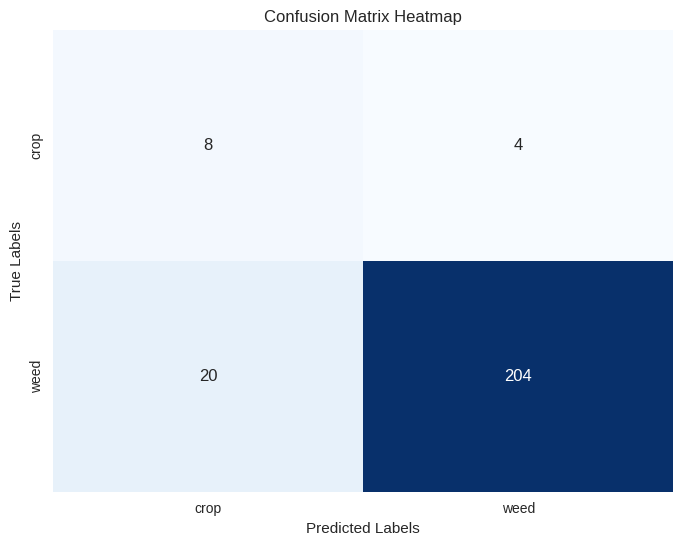

{'Accuracy sklearn': 0.8983050847457628,
 'Accuracy custom': 0.8983050847457628,
 'Conf Matrix': array([[  8,   4],
        [ 20, 204]]),
 'Recall crop': 0.6666666666666666,
 'Recall weed': 0.9107142857142857,
 'Precision crop': 0.2857142857142857,
 'Precision weed': 0.9807692307692307,
 'F1 crop': 0.4,
 'F1 weed': 0.9444444444444444}

In [102]:
eval_mod.evaluate(y_test, y_pred, print_cnfm=True)